In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,SimpleRNN,Flatten,Lambda,Conv1D,MaxPooling1D,BatchNormalization,Activation,Concatenate,Input,Add
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

In [2]:
class timeSeriesPredict:
  def __init__(self,countryName):
    self.country = countryName
  series = []
  model = 0
  x = []
  y = []
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  split_time = 0
  lr = .001
  optimizer = Adam(lr)
  loss = tf.keras.losses.MeanSquaredError()
  callbacks = []
  epochs = 500
  history = None


In [3]:
def get_series(file_path):
  sdate = datetime.datetime.strptime(starting_date, "%d%m%Y").date()
  with open(file_path) as f:
    reader = csv.reader(f,delimiter=',')
    next(reader)
    series = []
    c = 0
    dates = []
    for i in reader:
      try : 
        tmp = []
        tmp.append(float(i[5]))
        series.append(np.array(tmp))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
      except:
        series.append(np.array([0]))
        dates.append(sdate + datetime.timedelta(days = c))
        c += 1
        continue
    series = np.vstack(series)
    return series,dates



def create_windowed_dataset(series, window,begin):
  # series is a numpy array with shape (m,n_features)
  # this function returns x and y
  # x -> windowed data, numpy array of shape (m,n_features)
  # y -> labels for x, numpy array with shape(m,)
  m, n_features = series.shape
  i = begin
  x = []
  y = []
  while i < m :
    tmp = np.zeros((window,n_features))
    j = 0 if i-window >= 0 else window - i;
    tmp[j:window,:] = series[max(0,i-window):i,:] 
    x.append(tmp)
    y.append(series[i])
    i += 1
  return np.array(x), np.array(y)

def train_test_split(ratio,x,y):
  split_time = int(x.shape[0] * ratio)
  return x[0:split_time,:],x[split_time:,:],y[0:split_time],y[split_time:]

def moving_average(series,window):
  x = []
  m = series.shape[0]
  for i in range(m):
    b = i - window//2
    e = i + window//2
    inc = 0 if b > 0 else -b
    e += inc
    b += inc
    dec = 0 if e < m else e-m+1
    b -= dec
    e -= dec
    # print(b,e)
    x.append(np.sum(series[b:e+1,:]) / window)
  return np.array(np.expand_dims(x,1)) 

def plot(series,dates,fig=(5,3),label=None,title=None,interval=10,rotation=30,xlabel="Time",ylabel="New Cases"):
  fig = plt.figure(figsize = fig)
  ax = fig.add_subplot(111)
  plt.style.use("fivethirtyeight")

  n_lines = 2
  diff_linewidth = 1.05
  alpha_value = 0.1

  if dates != None:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.plot(dates,series,label = label,color='#00008B')
    #for n in range(1, n_lines+1):
     # ax.plot(dates,series,label = label,color='#00008B',
      #        linewidth=2+(diff_linewidth*n),
       #       alpha=alpha_value
        #      )
  else:
    ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B')
   # for n in range(1, n_lines+1):
    #  ax.plot([*range(1,len(series)+1)],series,label = label,color='#00008B',
     #         linewidth=2+(diff_linewidth*n),
      #        alpha=alpha_value
       #       )

  
  
              #ax=ax,
              #color=colors
  i=0
  for column in (series):
    ax.fill_between(x=i if dates==None else dates[i],
                    y1=column,
                    y2=[0] * len(series),
                    color='#00008B',
                    alpha=0.2)
    i=i+1
  

  
 # ax.plot(series,label = label,color='#FE53BB')
  ax.grid(color='#2A3459')
  ax.set_title(title,color='red')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  if label != None:
    ax.legend()
  plt.show()

def comp_plot(series1,series2,dates,figsize=(10,6),flabel='train',slabel='val',title=None,interval=10,rotation=30,pred=[]):

  
 # df.plot(marker='o', ax=ax, color=colors)

  plt.style.use("fivethirtyeight")
  
  


  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

  ax.grid(color='#2A3459')
  #ax.plot(series1,label = flabel)
  ax.plot(dates,series1,label = flabel,color='#00008B')
  #n_lines = 2
  #diff_linewidth = 1.05
  #alpha_value = 0.1
 
  i=0
 # for column in (series1):
  #  ax.fill_between(x=dates[i],
   #                 y1=column,
   #                 y2=[0] * len(series1),
    #                color='#00008B',
     #               alpha=0.2)
    #i=i+1




  
  z = dates+pred
  ax.plot(z,series2,label = slabel,color='#FFA500')
  
 
  i=0
  #for column in (series2):
   # ax.fill_between(x=z[i],
    #                y1=column,
     #               y2=[0] * len(series2),
      #              color='#FFA500',
       #             alpha=0.2)
    #i=i+1



  ax.set_xlabel('Time')
  ax.set_ylabel('New Cases')
  ax.set_title(title,color='red')
  # ax.spines['bottom'].set_color('red')
  # ax.spines['top'].set_color('red')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black',rotation=rotation)
  ax.yaxis.label.set_color('green')
  ax.tick_params(axis='y', colors='green')
  #ax.legend()
  plt.legend(['True Cases','Predicted Cases'])

  plt.show()


def forecast(model,x,window,days,tmn,tstd):
  y = model.predict(x)
  print(y.shape)
  for i in range(days) : 
    m = y.shape[0]
    tmp = y[-window:m]
    tmp = np.expand_dims(tmp,[0])
    tmp = (tmp - tmn) / tstd
    y = np.append(y,model.predict(tmp),axis= 0)
  
  return y


def mape(y1,y2):
  
  error=0
  cnt=0
  for i in range(y1.shape[0]):
    if y1[i]!=0:
      error=error+np.abs(y1[i]-y2[i])/y1[i]
      cnt=cnt+1
  error=error/cnt
  #print(error)
  error=error*100
  #error=convert_to_tensor(error)

  return error


def train_model(country):
  tf.keras.backend.clear_session()
  country.model.compile(loss=country.loss,metrics=['mse'],optimizer=country.optimizer)
  history = country.model.fit(x=country.x_train,y=country.y_train, validation_data = (country.x_val,country.y_val), epochs=country.epochs,verbose=1,batch_size=300,callbacks=country.callbacks)
  country.history = history
  # plot(history.history['mse'],None,fig=(12,6))
  # plot(history.history['val_mse'],None,fig=(12,6))
  

def show_plots(country):
  # plot(country.history.history['mse'],None,fig=(12,6),label='train_mse', title='train mse',xlabel="epochs",ylabel="mse")
  # plot(country.history.history['val_mse'],None,fig=(12,6), label='val_mse', title='val mse')
  y_actual=country.y
  y_predicted=country.model.predict(country.x)
  nRMSE_train=mean_squared_error(y_actual, y_predicted, squared=False)/np.mean(y_predicted)
  MAPE_train=mape(y_actual,y_predicted)
  comp_plot(country.y,country.model.predict(country.x),country.dates,
            title='entire series prediction',interval=interval,rotation=rotation)
  
  y_actual=country.y_val
  y_predicted=country.model.predict(country.x_val)
  nRMSE_val=mean_squared_error(y_actual, y_predicted, squared=False)/np.mean(y_predicted)
  MAPE_val=mape(y_actual,y_predicted)
  comp_plot(country.y_val,country.model.predict(country.x_val),country.dates[country.split_time:],
            title='Validation',interval=3,rotation=rotation)
  prediction_dates = []
  last = country.dates[-1];
  for i in range(1,41):
    prediction_dates.append(last+datetime.timedelta(days=i))
  comp_plot(country.y,forecast(country.model,country.x,window_size,40,0,1),country.dates,
            figsize=(12,10),title='Forecast',interval=interval,rotation=rotation,pred=prediction_dates)
  return nRMSE_train,nRMSE_val,MAPE_train,MAPE_val


In [4]:
def get_model():
  model = Sequential()
  model.add((LSTM(50,return_sequences=True,activation='relu', input_shape=(window_size, n_features))))
  model.add((LSTM(20,activation='relu')))
  model.add(Dense(1))
  return model


In [5]:
ratio = .9
window_size = 8
n_features = 1
interval = 10
rotation = 45

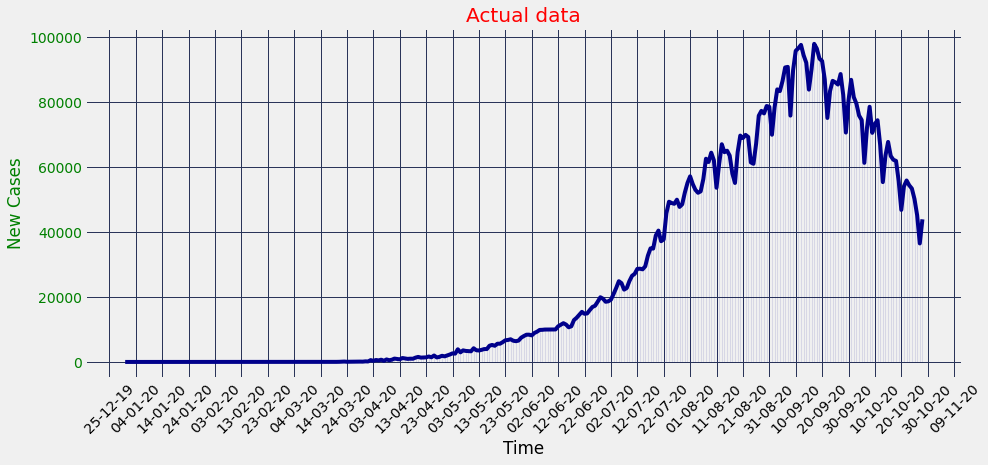

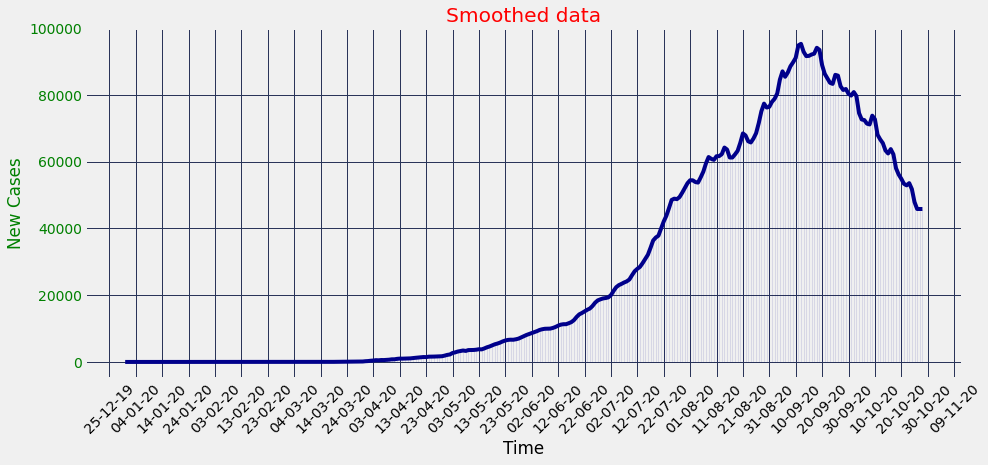

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
india = timeSeriesPredict("india")
india.series,india.dates = get_series('/content/India (5).csv')
plot(india.series,india.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
india.series = moving_average(india.series,5)
plot(india.series,india.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
india.x,india.y = create_windowed_dataset(india.series,8,0)
india.x_train,india.x_val,india.y_train,india.y_val = train_test_split(ratio,india.x,india.y)
india.model = get_model()
india.model.summary()
india.epochs = 1000
india.split_time = int(india.x.shape[0] * ratio)

In [ ]:
train_model(india)

Epoch 1/1000
1/1 [==============================] - 0s 305ms/step - loss: 1601687040.0000 - mse: 1601687040.0000 - val_loss: 5163907072.0000 - val_mse: 5163907072.0000
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 1519100160.0000 - mse: 1519100160.0000 - val_loss: 4775413760.0000 - val_mse: 4775413760.0000
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 1531579264.0000 - mse: 1531579264.0000 - val_loss: 4609854976.0000 - val_mse: 4609854976.0000
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - loss: 1470501632.0000 - mse: 1470501632.0000 - val_loss: 3381413120.0000 - val_mse: 3381413120.0000
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 1161929216.0000 - mse: 1161929216.0000 - val_loss: 3471967488.0000 - val_mse: 3471967488.0000
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 1156762496.0000 - mse: 1156762496.0000 - val_loss: 3487574528.0000 - val_mse: 3487574528.00

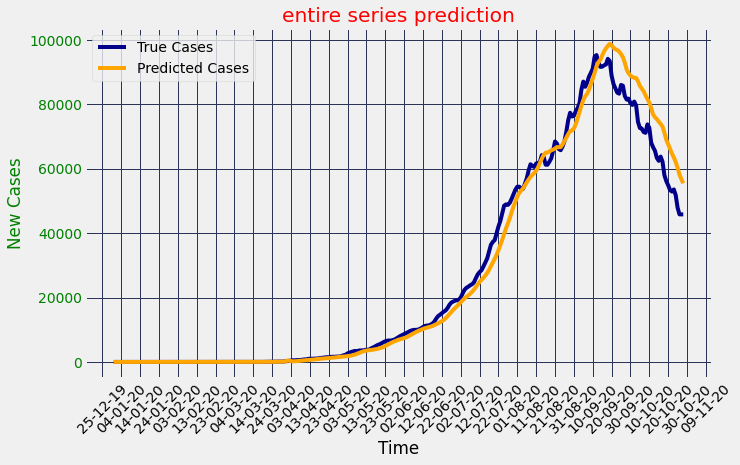

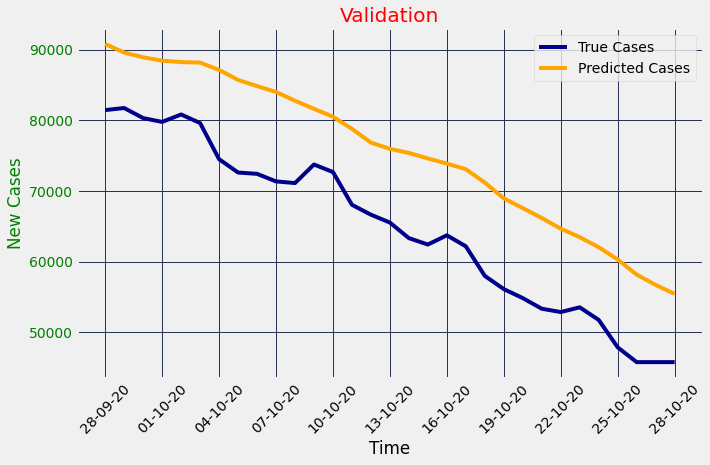

(303, 1)


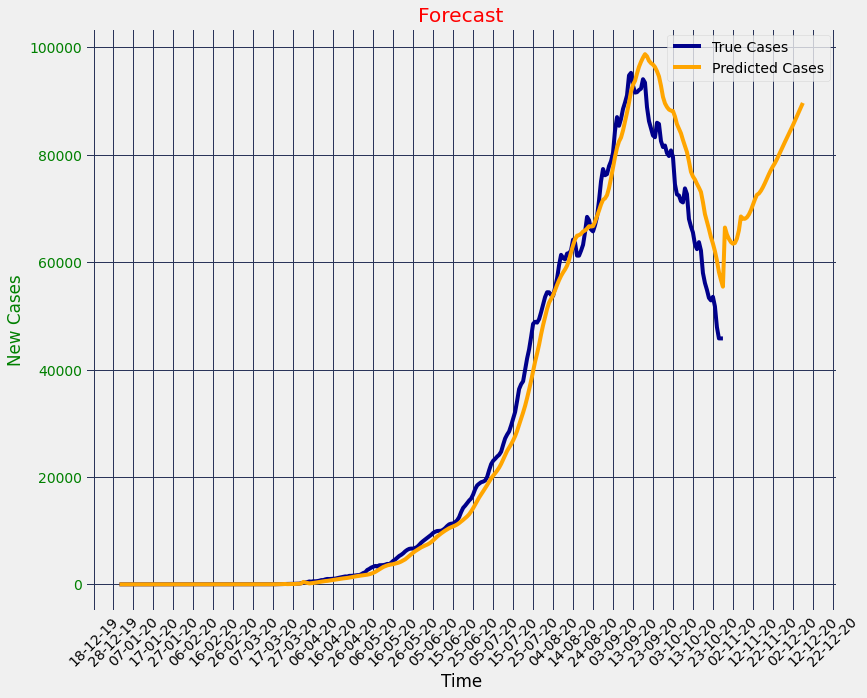

0.1657922140584956
0.14448079486270587
[18.58198818]
[17.43406176]


In [ ]:
show_plots(india)

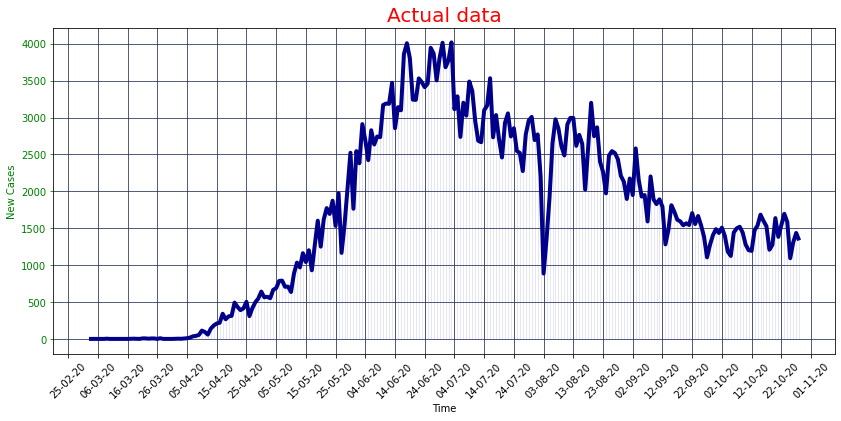

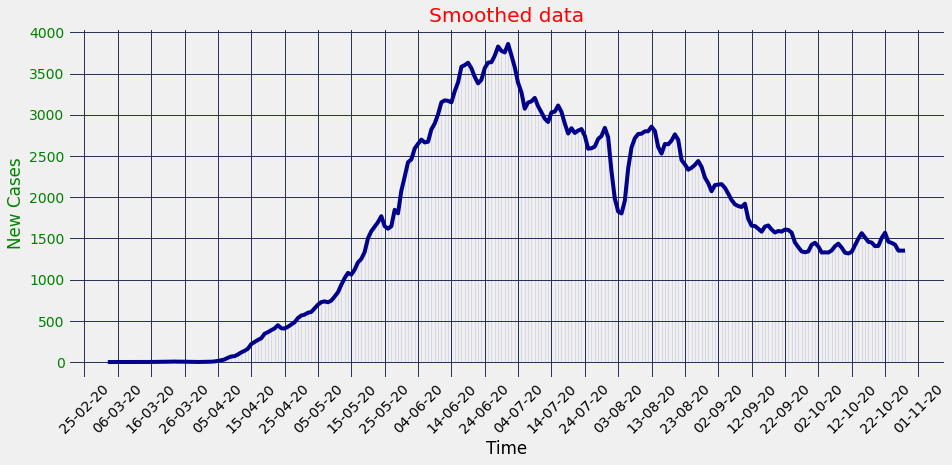

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "03032020"
bangladesh = timeSeriesPredict("Bangladesh")
country = bangladesh
country.series,country.dates = get_series('/content/Bangladesh.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 319ms/step - loss: 2853435.7500 - mse: 2853435.7500 - val_loss: 1061630.8750 - val_mse: 1061630.8750
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 2331792.2500 - mse: 2331792.2500 - val_loss: 939753.2500 - val_mse: 939753.2500
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 2105514.2500 - mse: 2105514.2500 - val_loss: 821546.0000 - val_mse: 821546.0000
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - loss: 1820210.2500 - mse: 1820210.2500 - val_loss: 762381.8125 - val_mse: 762381.8125
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 1739708.5000 - mse: 1739708.5000 - val_loss: 648044.8750 - val_mse: 648044.8750
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 1525439.3750 - mse: 1525439.3750 - val_loss: 888336.8125 - val_mse: 888336.8125
Epoch 7/1000
1/1 [==============================] - 0s 25ms/step - loss: 182791

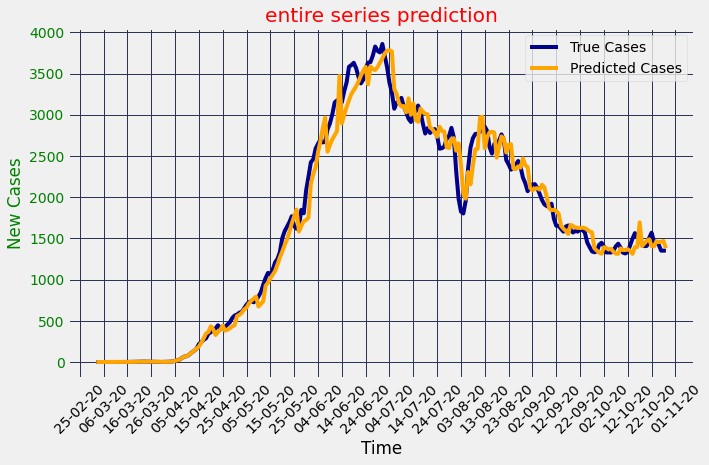

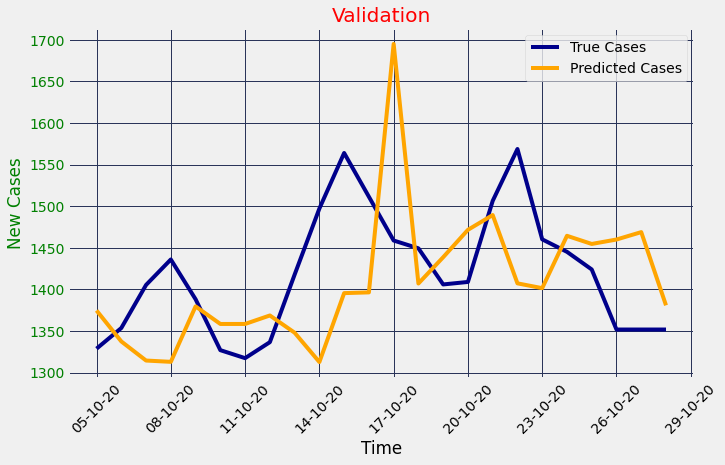

(240, 1)


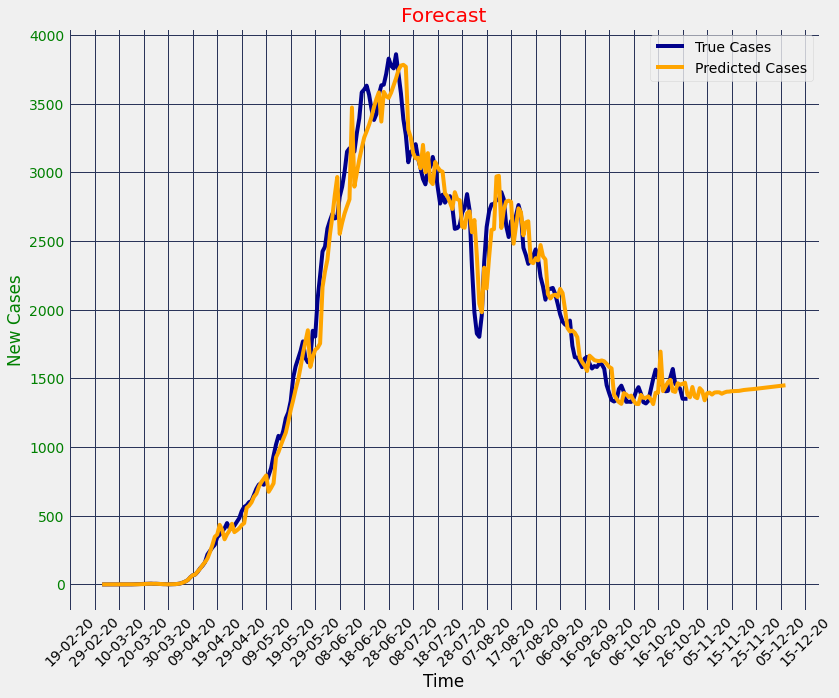

(0.09597197432899213,
 0.06952315985680774,
 array([7.81485806]),
 array([5.31003138]))

In [ ]:
show_plots(bangladesh)

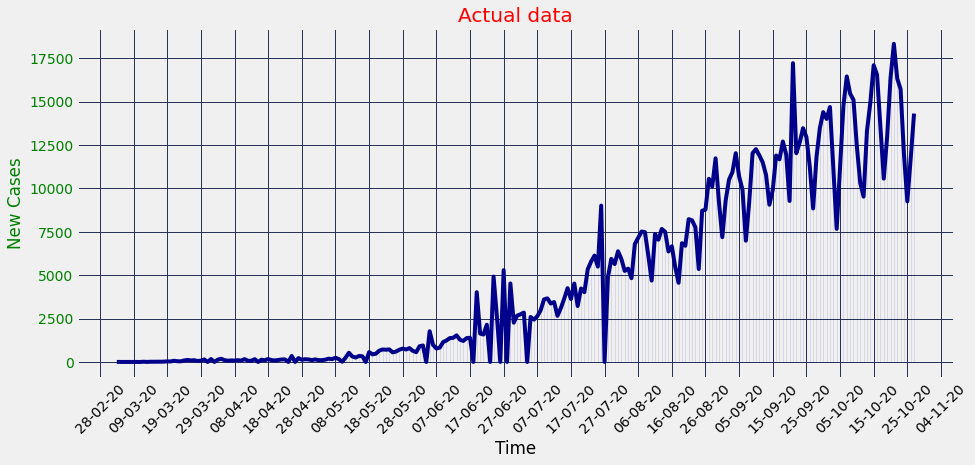

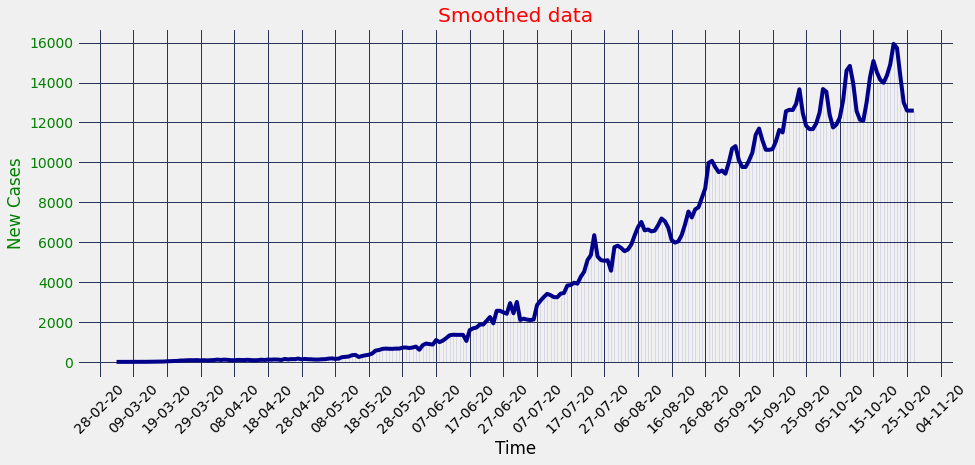

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "04032020"
argentina = timeSeriesPredict("Argentina")
country = argentina
country.series,country.dates = get_series('/content/Argentina.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(argentina)

Epoch 1/1000
1/1 [==============================] - 0s 282ms/step - loss: 35551948.0000 - mse: 35551948.0000 - val_loss: 216398208.0000 - val_mse: 216398208.0000
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 35564192.0000 - mse: 35564192.0000 - val_loss: 210063984.0000 - val_mse: 210063984.0000
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 34677888.0000 - mse: 34677888.0000 - val_loss: 209109008.0000 - val_mse: 209109008.0000
Epoch 4/1000
1/1 [==============================] - 0s 17ms/step - loss: 34566236.0000 - mse: 34566236.0000 - val_loss: 208699344.0000 - val_mse: 208699344.0000
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 34481748.0000 - mse: 34481748.0000 - val_loss: 196165776.0000 - val_mse: 196165776.0000
Epoch 6/1000
1/1 [==============================] - 0s 18ms/step - loss: 32575510.0000 - mse: 32575510.0000 - val_loss: 191380816.0000 - val_mse: 191380816.0000
Epoch 7/1000
1/1 [===============

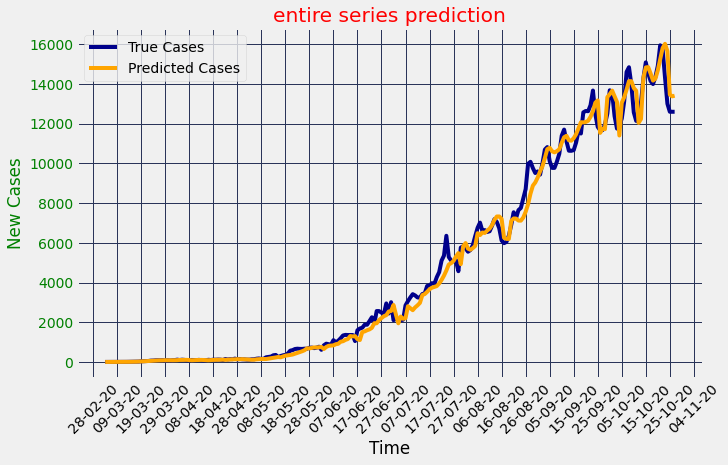

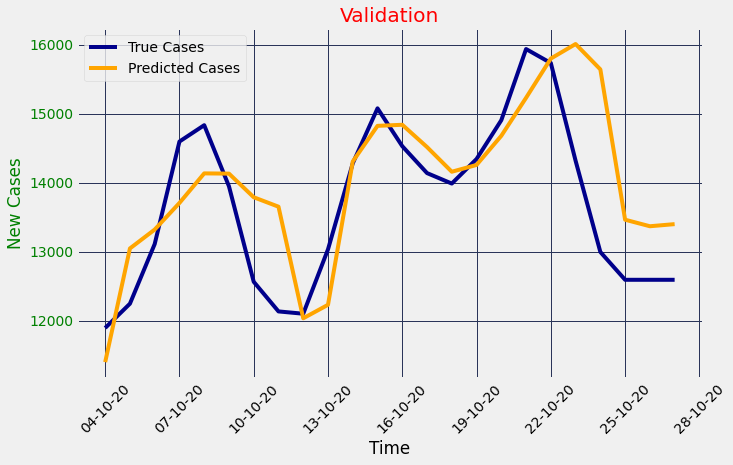

(238, 1)


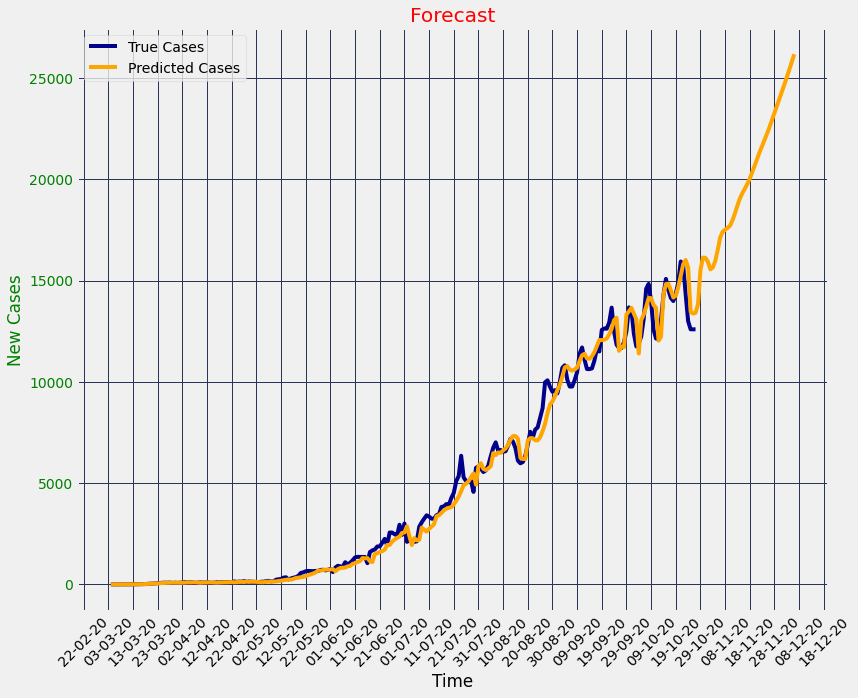

(0.10665531454175413,
 0.06437650116274253,
 array([10.2514348]),
 array([4.99919111]))

In [ ]:
show_plots(argentina)

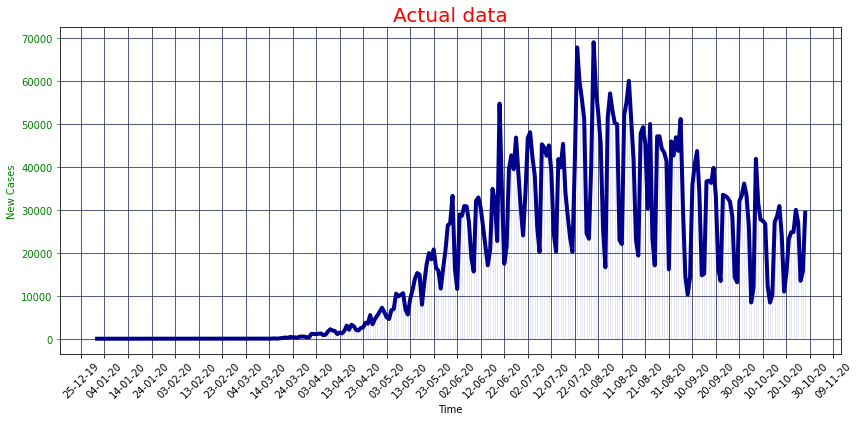

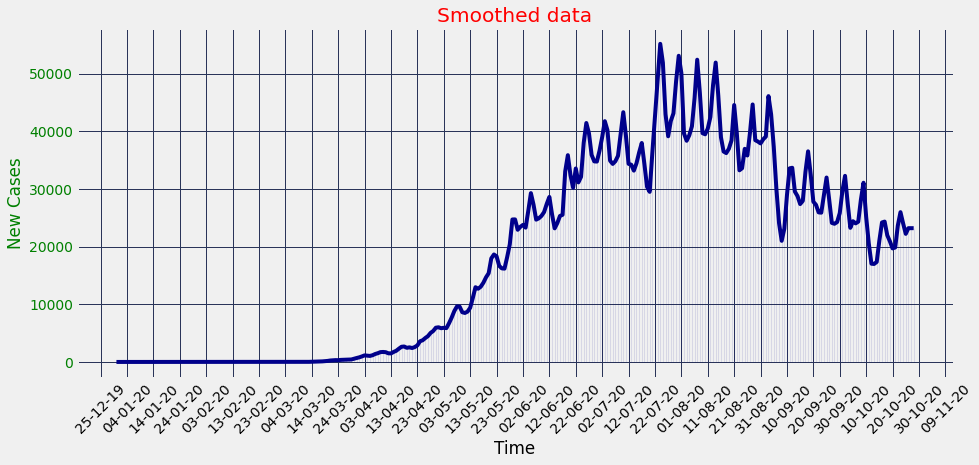

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [7]:
starting_date = "31122019"
brazil = timeSeriesPredict("Brazil")
country = brazil
country.series,country.dates = get_series('/content/Brazil.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [8]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 315ms/step - loss: 504175680.0000 - mse: 504175680.0000 - val_loss: 456076640.0000 - val_mse: 456076640.0000
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 483431680.0000 - mse: 483431680.0000 - val_loss: 459858176.0000 - val_mse: 459858176.0000
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 506567488.0000 - mse: 506567488.0000 - val_loss: 474759136.0000 - val_mse: 474759136.0000
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - loss: 511271328.0000 - mse: 511271328.0000 - val_loss: 476632544.0000 - val_mse: 476632544.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 503761632.0000 - mse: 503761632.0000 - val_loss: 478282528.0000 - val_mse: 478282528.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - loss: 506200128.0000 - mse: 506200128.0000 - val_loss: 477653248.0000 - val_mse: 477653248.0000
Epoch 7/1000
1/1 [===

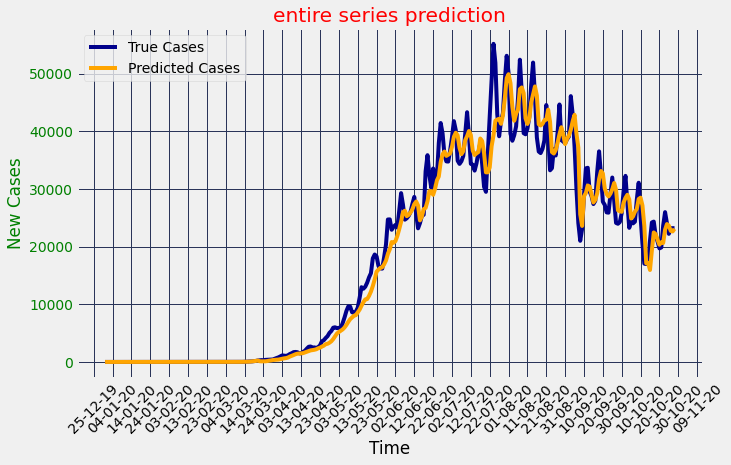

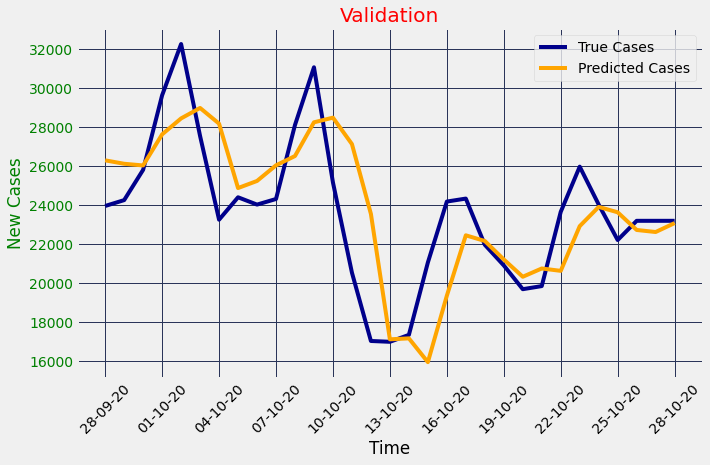

(303, 1)


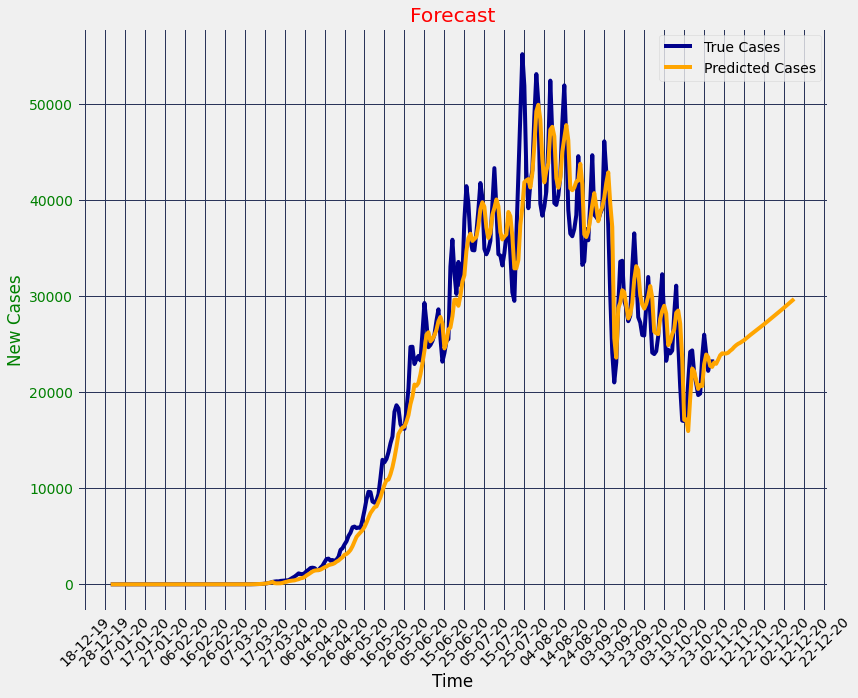

(0.1648227332255181,
 0.11729111642142089,
 array([14.92094812]),
 array([8.90582399]))

In [9]:
show_plots(brazil)

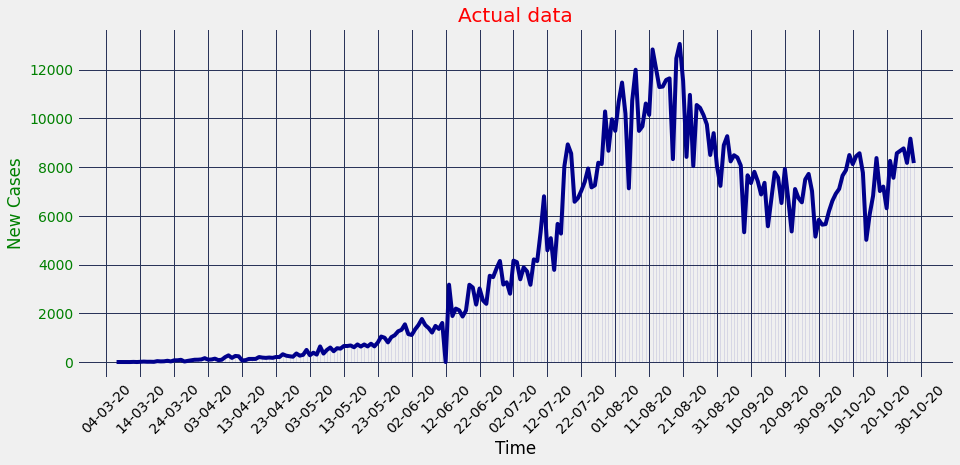

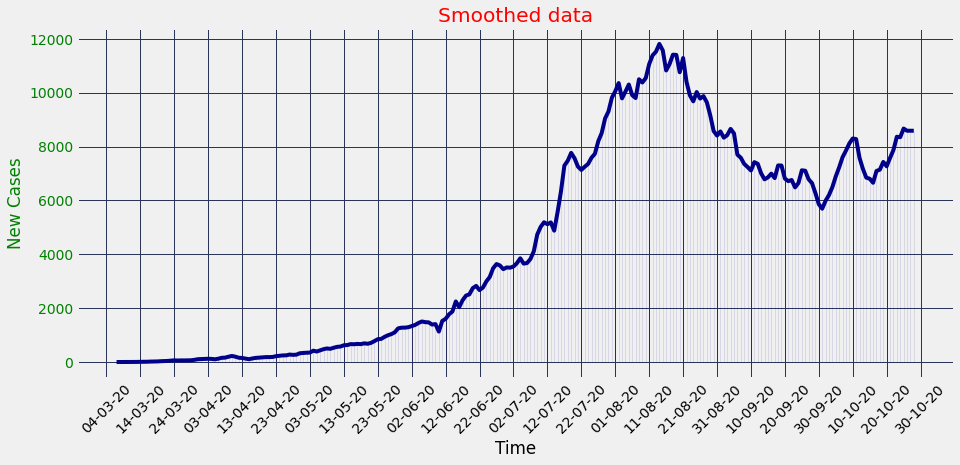

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "07032020"
colombia = timeSeriesPredict("Colombia")
country = colombia
country.series,country.dates = get_series('/content/Colombia.csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,8,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 307ms/step - loss: 42160456.0000 - mse: 42160456.0000 - val_loss: 74953848.0000 - val_mse: 74953848.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 39431312.0000 - mse: 39431312.0000 - val_loss: 73841560.0000 - val_mse: 73841560.0000
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 38272232.0000 - mse: 38272232.0000 - val_loss: 60009760.0000 - val_mse: 60009760.0000
Epoch 4/1000
1/1 [==============================] - 0s 17ms/step - loss: 28772010.0000 - mse: 28772010.0000 - val_loss: 32536800.0000 - val_mse: 32536800.0000
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 17826002.0000 - mse: 17826002.0000 - val_loss: 37227516.0000 - val_mse: 37227516.0000
Epoch 6/1000
1/1 [==============================] - 0s 17ms/step - loss: 18843946.0000 - mse: 18843946.0000 - val_loss: 29353898.0000 - val_mse: 29353898.0000
Epoch 7/1000
1/1 [===========================

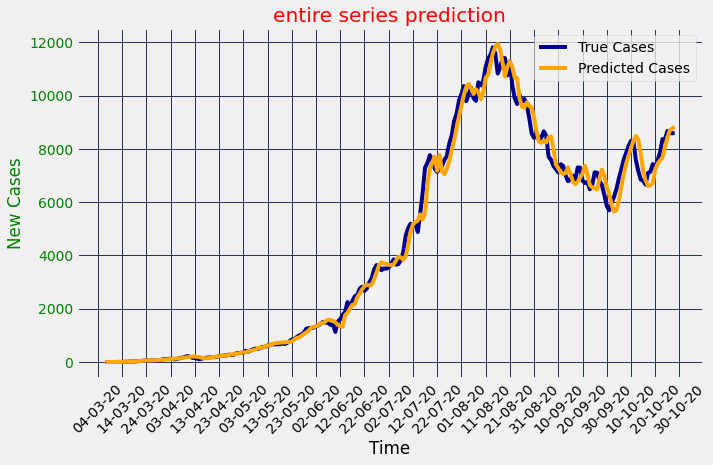

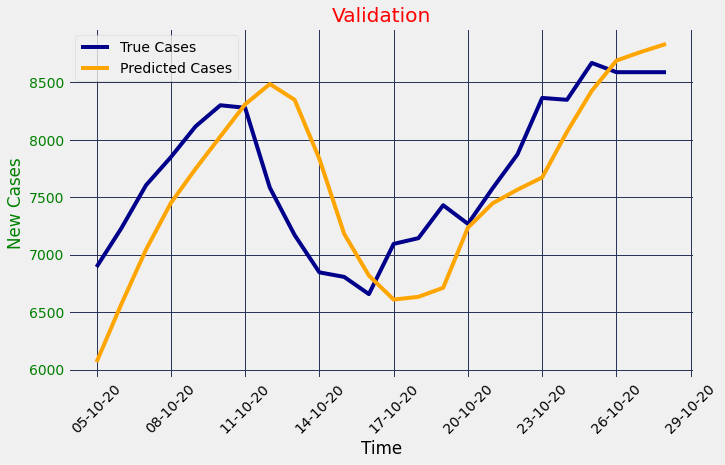

(236, 1)


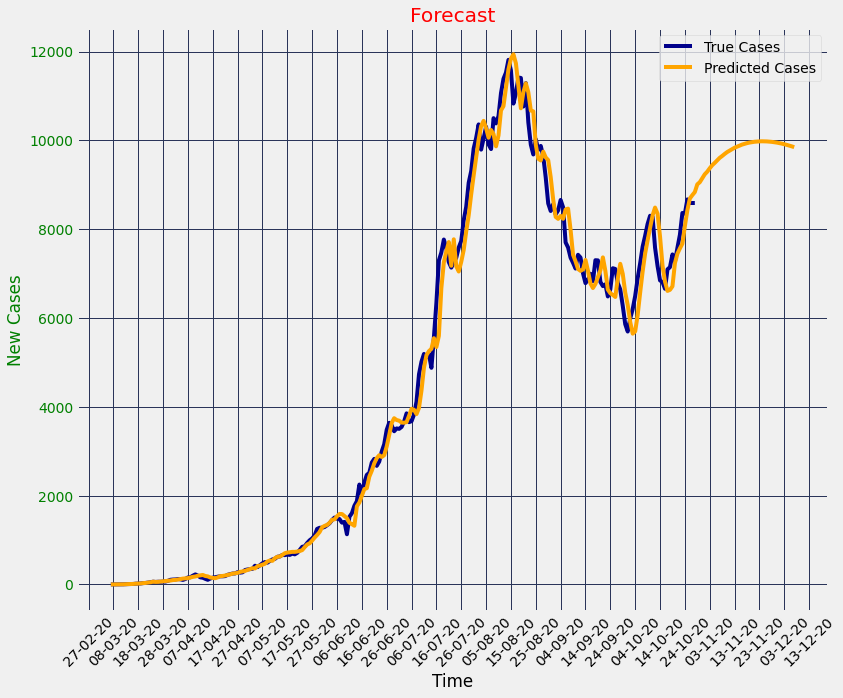

(0.08632053940139563,
 0.07096295758308796,
 array([6.7196243]),
 array([5.94692607]))

In [ ]:
show_plots(colombia)

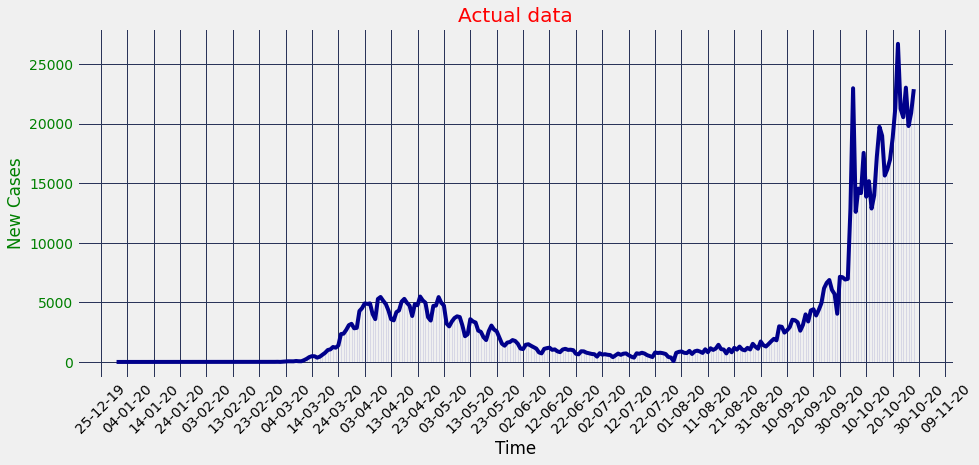

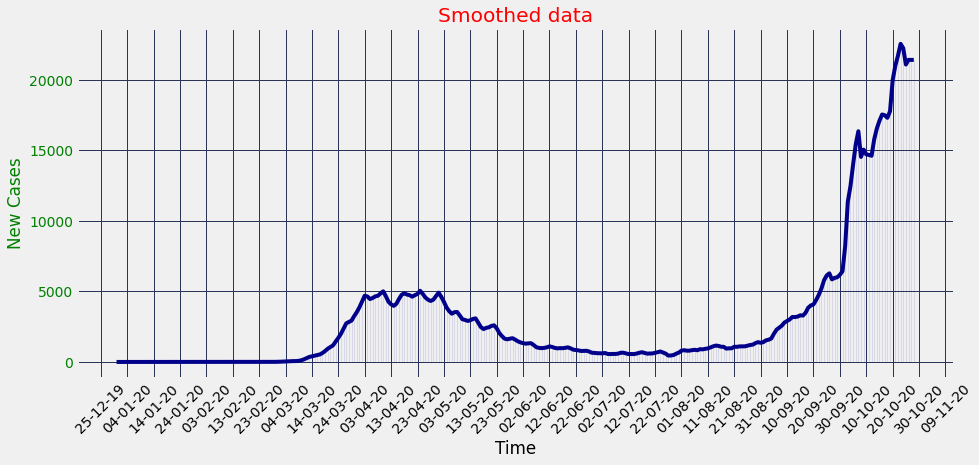

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
uk = timeSeriesPredict("UK")
country = uk
country.series,country.dates = get_series('/content/United Kingdom (3).csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,window_size,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 311ms/step - loss: 4482328.5000 - mse: 4482328.5000 - val_loss: 221024656.0000 - val_mse: 221024656.0000
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 4181433.5000 - mse: 4181433.5000 - val_loss: 234203168.0000 - val_mse: 234203168.0000
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 4426028.0000 - mse: 4426028.0000 - val_loss: 223574176.0000 - val_mse: 223574176.0000
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 4151621.7500 - mse: 4151621.7500 - val_loss: 202523456.0000 - val_mse: 202523456.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 3415376.0000 - mse: 3415376.0000 - val_loss: 146531872.0000 - val_mse: 146531872.0000
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 2468452.7500 - mse: 2468452.7500 - val_loss: 192607824.0000 - val_mse: 192607824.0000
Epoch 7/1000
1/1 [===========================

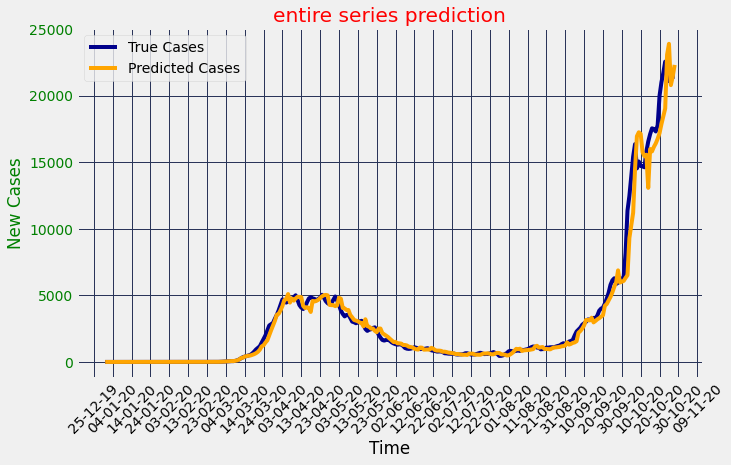

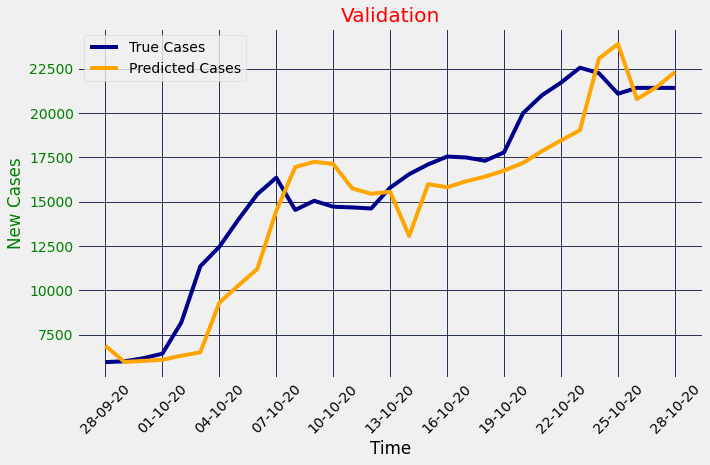

(303, 1)


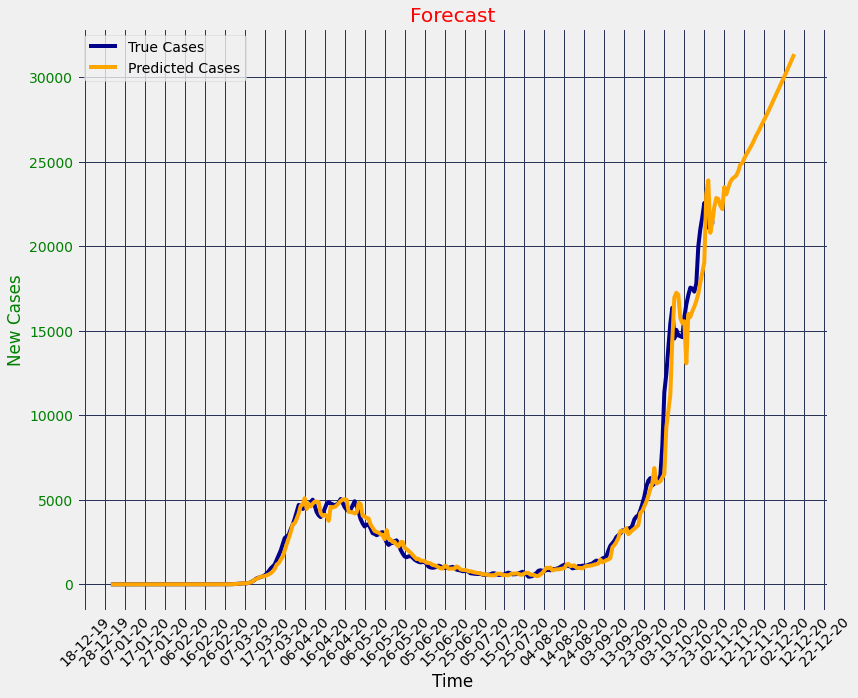

(0.2656906916320982,
 0.15422713539102864,
 array([16.35994291]),
 array([12.32145979]))

In [ ]:
show_plots(uk)

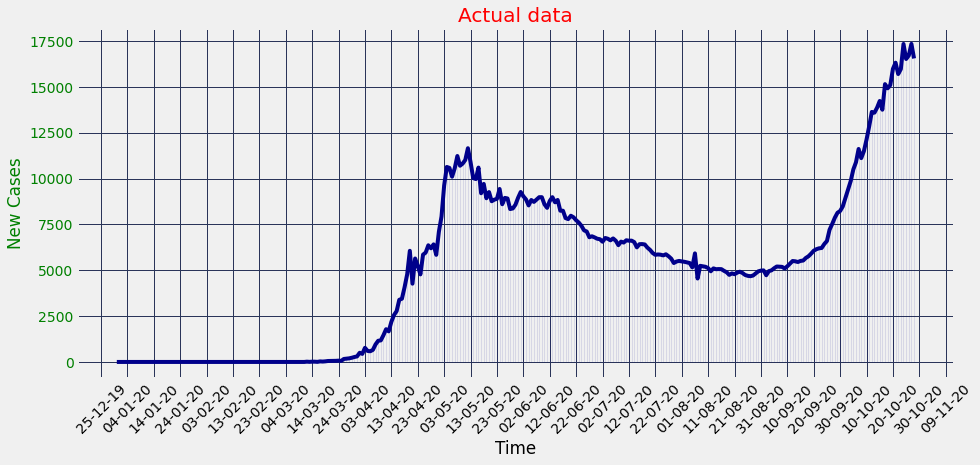

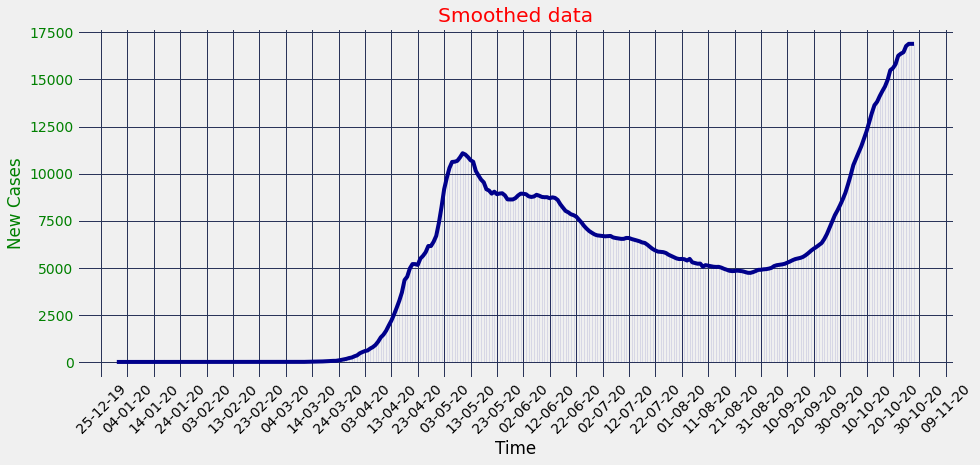

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
starting_date = "31122019"
russia = timeSeriesPredict("Russia")
country = russia
country.series,country.dates = get_series('/content/Russia (5).csv')
plot(country.series,country.dates,fig=(14,6),title='Actual data',interval=interval,rotation=rotation)
country.series = moving_average(country.series,5)
plot(country.series,country.dates,fig=(14,6),title='Smoothed data',interval=interval,rotation=rotation)
country.x,country.y = create_windowed_dataset(country.series,10,0)
country.x_train,country.x_val,country.y_train,country.y_val = train_test_split(ratio,country.x,country.y)
country.model = get_model()
country.model.summary()
country.epochs = 1000
country.split_time = int(country.x.shape[0] * ratio)

In [ ]:
train_model(country)

Epoch 1/1000
1/1 [==============================] - 0s 315ms/step - loss: 28371776.0000 - mse: 28371776.0000 - val_loss: 185761984.0000 - val_mse: 185761984.0000
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 31447424.0000 - mse: 31447424.0000 - val_loss: 180841776.0000 - val_mse: 180841776.0000
Epoch 3/1000
1/1 [==============================] - 0s 22ms/step - loss: 30682692.0000 - mse: 30682692.0000 - val_loss: 173340176.0000 - val_mse: 173340176.0000
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 29033560.0000 - mse: 29033560.0000 - val_loss: 148005776.0000 - val_mse: 148005776.0000
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 24525846.0000 - mse: 24525846.0000 - val_loss: 54953116.0000 - val_mse: 54953116.0000
Epoch 6/1000
1/1 [==============================] - 0s 23ms/step - loss: 19163584.0000 - mse: 19163584.0000 - val_loss: 113560808.0000 - val_mse: 113560808.0000
Epoch 7/1000
1/1 [=================

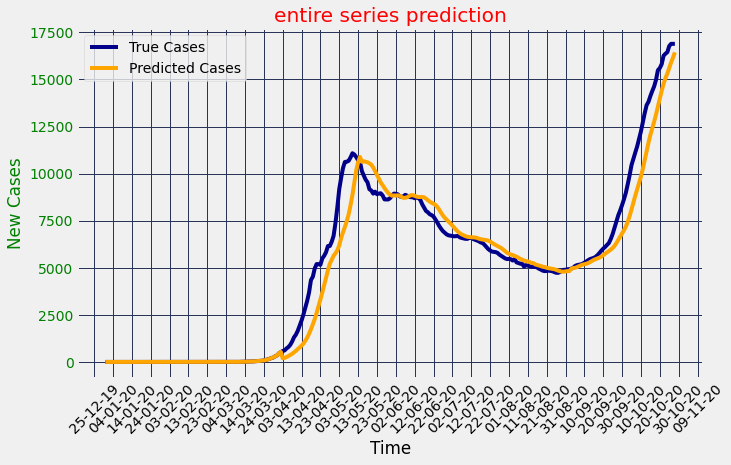

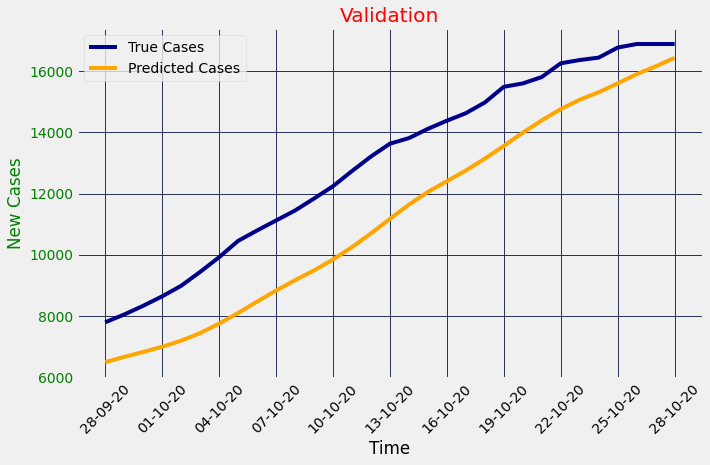

(303, 1)


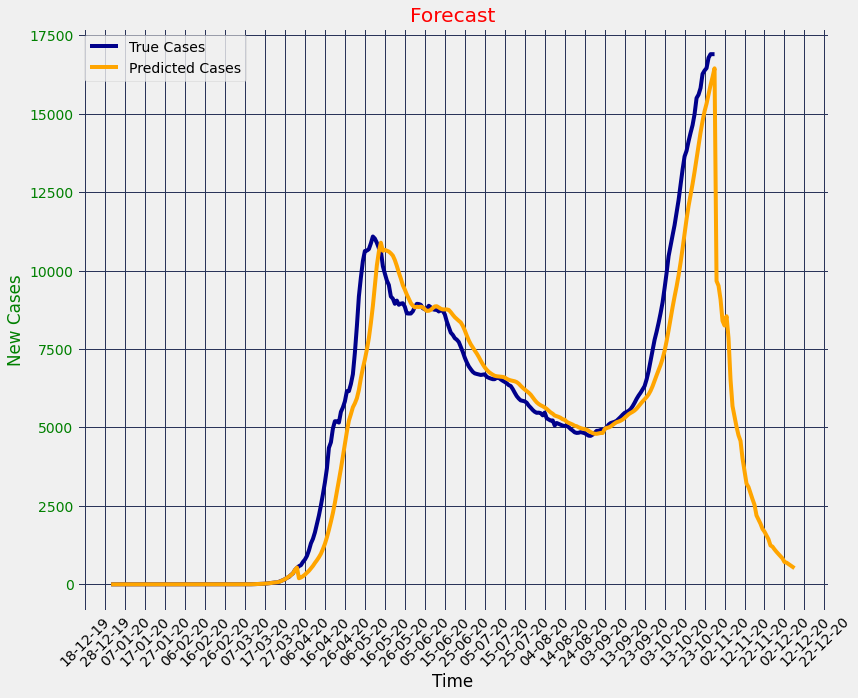

(0.20348760103001962,
 0.1661907955422688,
 array([14.02981754]),
 array([14.82955581]))

In [ ]:
show_plots(russia)

In [ ]:
# model = tf.keras.Sequential([
                               
  #                              Conv1D(32,3,1,input_shape=(window_size,n_features)),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(64,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(128,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Conv1D(256,3,1),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                             #  Conv1D(512,3,1,activation='relu'),
  #                             #  BatchNormalization(),
  #                             #  Activation('relu'),
  #                             #  Conv1D(1024,3,1,activation='relu'),
  #                              Flatten(),
  #                             #  Dense(100),
  #                              Dense(10),
  #                              BatchNormalization(),
  #                              Activation('relu'),
  #                              Dense(1,activation='relu')
  # ])

  # input = Input(shape=(window_size,n_features))
  # x = Conv1D(32,3,1)(input)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(64,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(128,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = inception_A(x)
  # x = Conv1D(256,3,1)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # # x = LSTM(8)(x)
  # x = Flatten()(x)
  # x = Dense(10)(x)
  # # x = BatchNormalization()(x)
  # x = Activation('relu')(x)
  # x = Dense(1,activation='relu')(x)

  # model = Model(input,x)

In [ ]:
def inception_A(x):
  p1 = Conv1D(64,3,1,padding='same')(x)
  p2 = Conv1D(64,5,1,padding='same')(x)
  p3 = Conv1D(64,7,1,padding='same')(x)
  p4 = Conv1D(64,9,1,padding='same')(x)
  x = Add()([p1,p2,p3,p4])
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x


In [ ]:
series,time = get_series('/content/Bangladesh.csv')
series = moving_average(series,5)
print(len(series))
plot(series,fig=(10,6))

In [ ]:
def scheduler(epoch , lr):
    lr = .01;
    c = int(epoch / 1000);
    lr /= 1 if c < 1 else c*10
    return lr

lr_reg = tf.keras.callbacks.LearningRateScheduler(scheduler)
tf.keras.backend.clear_session()
# model = get_model()
epochs = 1000
opt = Adam(learning_rate=.001)
# opt = SGD(lr=.1)
loss = tf.keras.losses.MeanSquaredError()
# loss = tf.keras.losses.Huber(delta = 1000)
model.compile(loss=loss,metrics=['mse'],optimizer=opt)
history = model.fit(x=x_train,y=y_train, validation_data = (x_val,y_val), epochs=epochs,verbose=1,batch_size=300)#,callbacks=[lr_reg])
# plot(history.history['loss'],0,1000)
plot(history.history['mse'],0,epochs,fig=(12,6))
plot(history.history['val_mse'],0,epochs,fig=(12,6))

In [ ]:
comp_plot(india.y_val,india.model.predict(india.x_val))

In [ ]:
ratio = .85
window_size = 20
n_features = series.shape[1]
x,y = create_windowed_dataset(series,window_size,0)
split_time = int(x.shape[0] * ratio)
# tmn,tstd = np.mean(x[0:split_time,:]),np.linalg.norm(x[0:split_time,:])
# vmn,vstd = np.mean(x[split_time:,:]),np.linalg.norm(x[split_time:,:])
# x = (x - tmn) / tstd
x_train,x_val,y_train,y_val = train_test_split(ratio,x,y)

In [ ]:
comp_plot(india.y,india.model.predict(india.x))

In [ ]:
comp_plot(india.y,forecast(india.model,india.x,window_size,40,0,1),figsize=(12,10))

In [ ]:
plot(india.history.history['mse'],500,india.epochs,fig=(12,6))
plot(india.history.history['val_mse'],500,india.epochs,fig=(12,6))

In [ ]:
model = get_model()
model.summary()

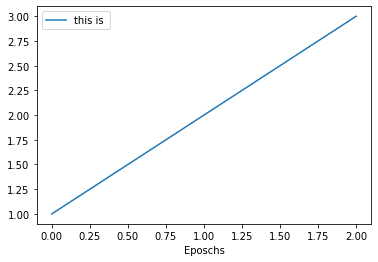

In [ ]:
plt.plot([1,2,3],label = "this is ")
plt.xlabel('Eposchs')
plt.legend()

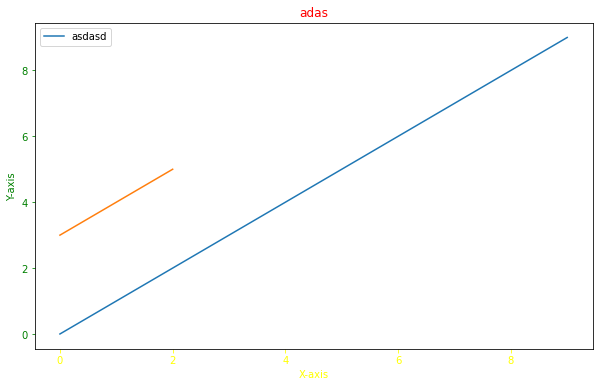

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(10),label = "asdasd")
ax.plot([3,4,5])
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title("adas",color='red')
# ax.spines['bottom'].set_color('blue')
# ax.spines['top'].set_color('blue')
ax.xaxis.label.set_color('yellow')
ax.tick_params(axis='x', colors='yellow')
ax.yaxis.label.set_color('green')
ax.tick_params(axis='y', colors='green')

plt.show()